線形回帰を行うときの重要な仮定は

* 残差が独立同分布になっている

である.  よく言われている条件

* 残差が正規分布に従うこと

は必須の条件ではない.  残差が正規分布に従うことは必要ないし, 残差の分布が正規分布に従っていても i.i.d. になっていなければ線形回帰の適用は不適切であると考えられる.

もちろん, 残差が正規分布以外の分布のi.i.d.になっている場合には, 誤差が大きくなることはありえるので要注意である.

残差が正規分布以外の分布のi.i.d.になっているように見える場合には, 観測していない独立変数に $y$ が非線形に依存している可能性を疑う必要があるかもしれない.

In [1]:
using Distributions
using KernelDensity
using LinearAlgebra
dot2(x) = dot(x, x)
using Optim
using Random
using StatsFuns
using StatsPlots
default(fmt=:png, titlefontsize=10, tickfontsize=6, guidefontsize=8, legendfontsize=8)

In [2]:
Random.seed!(4649373)

disty(x,a,b,c,d,s,t) = MixtureModel(
    [Normal(a + b*x, exp(s)), Normal(c + d*x , exp(t))],
    fill(1/2, 2))

function plot_mixedcase(; n=10^3, distx=Normal(0,2), disty=disty,
        w_true=Float64[2, 1, 2, 3, log(1), log(1)])
    x = rand(distx, n)
    y = @. rand(disty(x, w_true...))
    X = x .^ (0:1)'
    @show β̂ = X \ y
    ŷ = X * β̂

    P1 = scatter(x, y; label="data: (x, y)", msc=:auto, alpha=0.5, ms=2)
    plot!(x -> [1,x]'*β̂; label="simple regression line: (x, ŷ)", lw=1.5)

    P2 = scatter(x, y - ŷ; label="residual error: (x, y - ŷ)", msc=:auto, alpha=0.5, ms=2)
    hline!([0]; label="", lw=1.5)

    P3 = stephist(y - ŷ; norm=true, label="histogram of residual error y - ŷ")
    plot!(fit(Normal, y - ŷ); label="normal approximation")
    
    negloglik(a, b, c, d, s, t) = -logsumexp(logpdf(disty(x,a,b,c,d,s,t), y) for (x, y) in zip(x, y))
    o = optimize(w -> negloglik(w..., 0, 0), w_true[1:4], LBFGS())
    @show o
    @show w_true[1:4]
    @show â, b̂, ĉ, d̂ = o.minimizer

    Q1 = scatter(x, y; label="", msc=:auto, alpha=0.5, ms=2)
    plot!(x -> â + b̂*x; label="regression line 1", ls=:dash, lw=1.5, c=2)
    plot!(x -> ĉ + d̂*x; label="regression line 2", ls=:dashdot, lw=1.5, c=2)

    plot(P1, P2, P3, Q1; size=(800, 600), legend=:outertop, layout=(2, 2))
end

plot_mixedcase (generic function with 1 method)

β̂ = X \ y = [2.0800931906770157, 2.089289168325404]
o =  * Status: success

 * Candidate solution
    Final objective value:     -5.209981e+00

 * Found with
    Algorithm:     L-BFGS

 * Convergence measures
    |x - x'|               = 1.14e-06 ≰ 0.0e+00
    |x - x'|/|x'|          = 3.87e-07 ≰ 0.0e+00
    |f(x) - f(x')|         = 5.12e-13 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 9.82e-14 ≰ 0.0e+00
    |g(x)|                 = 7.21e-10 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    7
    f(x) calls:    21
    ∇f(x) calls:   21

w_true[1:4] = [2.0, 1.0, 2.0, 3.0]
(â, b̂, ĉ, d̂) = o.minimizer = [1.9662548727016729, 1.1184506093120639, 2.1637189931479712, 2.941148498248878]


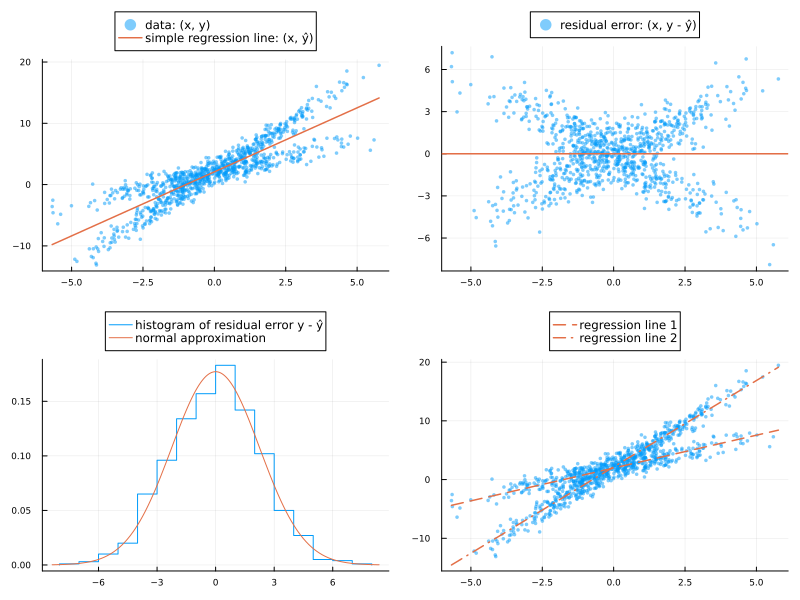

In [3]:
plot_mixedcase()

以下は残差が非正規分布になっている場合.

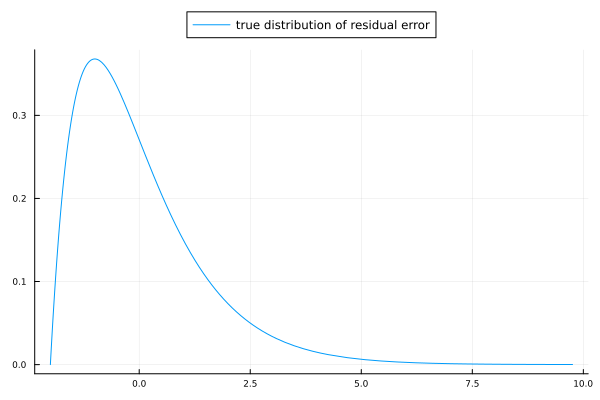

In [4]:
_distu = Gamma(2, 1)
distu = _distu - mean(_distu)

plot(distu; label="true distribution of residual error", legend=:outertop)

In [5]:
function plot_ols(; n = 1000,
        distx = Normal(0, 2), a=1.0, b=1.0,
        _distu = Gamma(2, 1), distu = _distu - mean(_distu),
        qthreshold = 0.01,
        xlim=quantile.(distx, (qthreshold, 1-qthreshold)),
        ylim=quantile.(distu, (qthreshold, 1-qthreshold)))
    x = rand(distx, n)
    y = @. a + b*x + rand(distu)

    @show distx
    @show distu
    @show n
    println()
    
    X = x .^ (0:1)'
    @show β̂_true = [a, b]
    @show β̂ = X \ y
    println()
    
    ŷ = X * β̂
    @show σ_true = √var(distu)
    @show √(dot2(y - ŷ)/(n - size(X, 2)))
    
    P1 = scatter(x, y; label="data: (x, y)", msc=:auto, alpha=0.5, ms=2)
    plot!(x -> [1,x]'*β̂; label="simple regression line: (x, ŷ)", lw=1.5)

    P2 = scatter(x, y - ŷ; label="residual error: (x, y - ŷ)", msc=:auto, alpha=0.5, ms=2)
    hline!([0]; label="", lw=1.5)

    P3 = stephist(y - ŷ; norm=true, label="histogram of residual error y - ŷ")
    plot!(fit(Normal, y - ŷ); label="normal approximation")
    plot!(distu; label="true distribution of residual error")

    ikx = InterpKDE(kde(x))
    ikxy = InterpKDE(kde((x, y-ŷ)))
    f(x, y) = pdf(ikxy, x, y) / pdf(ikx, x)
    xs = range(xlim..., 20)
    ys = range(ylim..., 20)

    P4 = heatmap(xs, ys, f; colorbar=false, title="conditional distribution of residual error")

    plot(P1, P2, P3, P4; size=(800, 600), legend=:outertop, layout=(2, 2))
end

plot_ols (generic function with 1 method)

distx = Normal{Float64}(μ=0.0, σ=2.0)
distu = LocationScale{Float64, Continuous, Gamma{Float64}}(
μ: -2.0
σ: 1.0
ρ: Gamma{Float64}(α=2.0, θ=1.0)
)

n = 1000

β̂_true = [a, b] = [1.0, 1.0]
β̂ = X \ y = [1.0062061408246705, 0.9896083341200951]

σ_true = √(var(distu)) = 1.4142135623730951
√(dot2(y - ŷ) / (n - size(X, 2))) = 1.4695809015350887


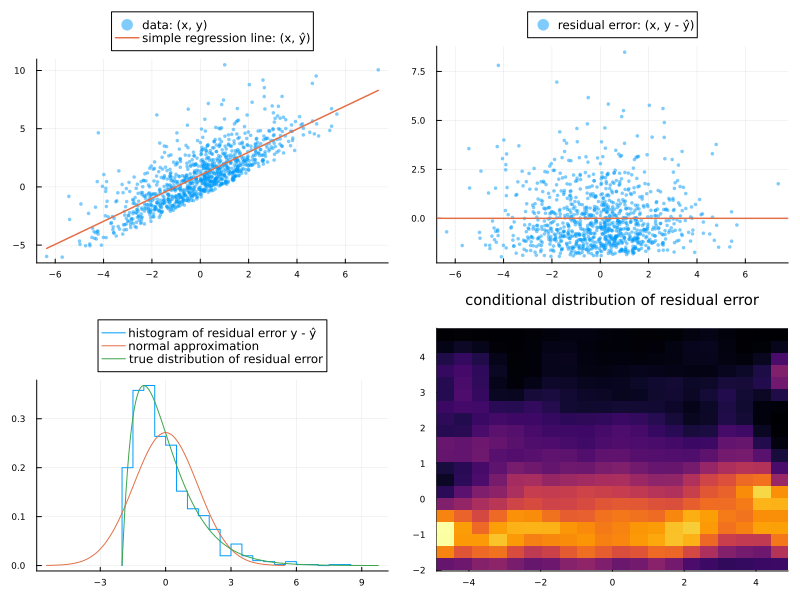

In [6]:
plot_ols()

distx = Normal{Float64}(μ=0.0, σ=2.0)
distu = LocationScale{Float64, Continuous, Gamma{Float64}}(
μ: -2.0
σ: 1.0
ρ: Gamma{Float64}(α=2.0, θ=1.0)
)

n = 100

β̂_true = [a, b] = [1.0, 1.0]
β̂ = X \ y = [1.1997035613252653, 1.0552912879155003]

σ_true = √(var(distu)) = 1.4142135623730951
√(dot2(y - ŷ) / (n - size(X, 2))) = 1.528936468691976


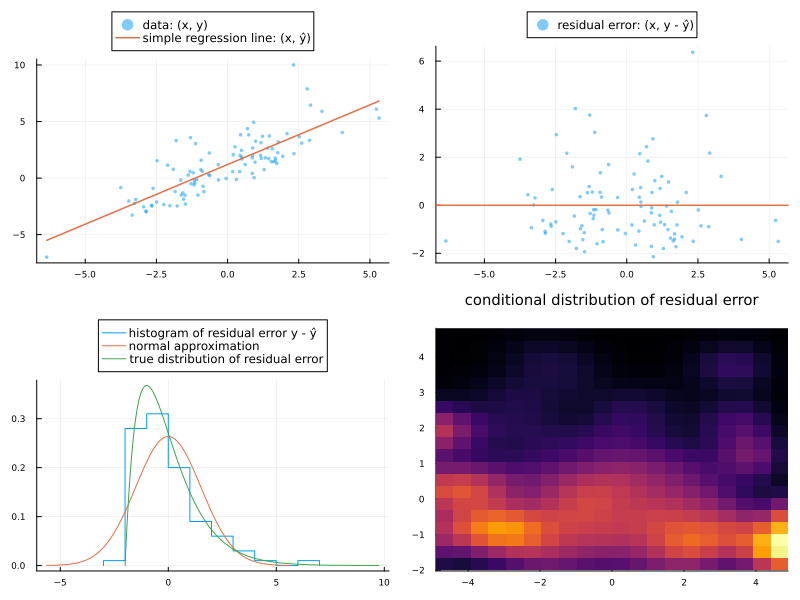

In [7]:
plot_ols(; n=100)

このような場合であっても, $\hat\beta$ の分布は2変量正規分布で近似される.  以下でそのことを確認しよう.

In [8]:
function sim(distx, a, b, distu, n; L=10^5)
    tmpx = [Vector{Float64}(undef, n) for _ in 1:Threads.nthreads()]
    tmpu = [Vector{Float64}(undef, n) for _ in 1:Threads.nthreads()]
    tmpy = [Vector{Float64}(undef, n) for _ in 1:Threads.nthreads()]
    tmpX = [Matrix{Float64}(undef, n, 2) for _ in 1:Threads.nthreads()]
    β̂ = [Vector{Float64}(undef, 2) for _ in 1:L]
    Threads.@threads for i in 1:L
        tid = Threads.threadid()
        x = rand!(distx, tmpx[tid])
        u = rand!(distu, tmpu[tid])
        y = @. tmpy[tid] = a + b*x + u
        tmpX[tid][:,1] .= 1
        tmpX[tid][:,2] .= x
        X = tmpX[tid]
        β̂[i] = X \ y
    end
    β̂
end

# 回帰係数の分布は以下の分布に漸近する.
function mvnormalapprox_true(; n = 1000,
        distx = Normal(0, 2),
        a = 1.0, b = 1.0,
        _distu = Gamma(2, 1), distu = _distu - mean(_distu))
    μx = mean(distx)
    σx² = var(distx)
    σ² = var(distu)
    μ_true = [a, b]
    Σ_true = σ²/(n*σx²)*[σx²+μx^2 -μx; -μx 1]
    MvNormal(μ_true, Σ_true)
end

mvnormalapprox_true (generic function with 1 method)

In [9]:
function plot_betahat(; n = 1000,
        distx = Normal(0, 2),
        a = 1.0, b = 1.0,
        _distu = Gamma(2, 1), distu = _distu - mean(_distu),
        L=10^5)
    @show distx
    @show distu
    @show n
    println()
    
    β̂ = sim(distx, a, b, distu, n; L)
    @show mvnormalapprox_true(; n, distx, a, b, _distu, distu)
    @show fit(MvNormal, stack(β̂))

    β̂₀, β̂₁ = getindex.(β̂, 1)[begin:min(end,10000)], getindex.(β̂, 2)[begin:min(end,10000)]
    Q1 = scatter(β̂₀, β̂₁; label="", msc=:auto, alpha=0.5, ms=1)
    title!("distribution of regression coefficients")
    Q2 = stephist(β̂₀; norm=true, label="")
    plot!(fit(Normal, β̂₀); label="normal approx.")
    title!("distribution of first coefficients")
    Q3 = stephist(β̂₁; norm=true, label="")
    plot!(fit(Normal, β̂₁); label="normal approx.")
    title!("distribution of second coefficients")

    plot(Q1, Q3, Q2; size=(800, 600))
end

plot_betahat (generic function with 1 method)

distx = Normal{Float64}(μ=0.0, σ=2.0)
distu = LocationScale{Float64, Continuous, Gamma{Float64}}(
μ: -2.0
σ: 1.0
ρ: Gamma{Float64}(α=2.0, θ=1.0)
)

n = 1000

mvnormalapprox_true(; n, distx, a, b, _distu, distu) = FullNormal(
dim: 2
μ: [1.0, 1.0]
Σ: [0.002 -0.0; -0.0 0.0005]
)

fit(MvNormal, stack(β̂)) = FullNormal(
dim: 2
μ: [0.9997991385749369, 0.9999654874207351]
Σ: [0.0020091824429802293 6.150035916722452e-6; 6.150035916722452e-6 0.0004984416316999643]
)



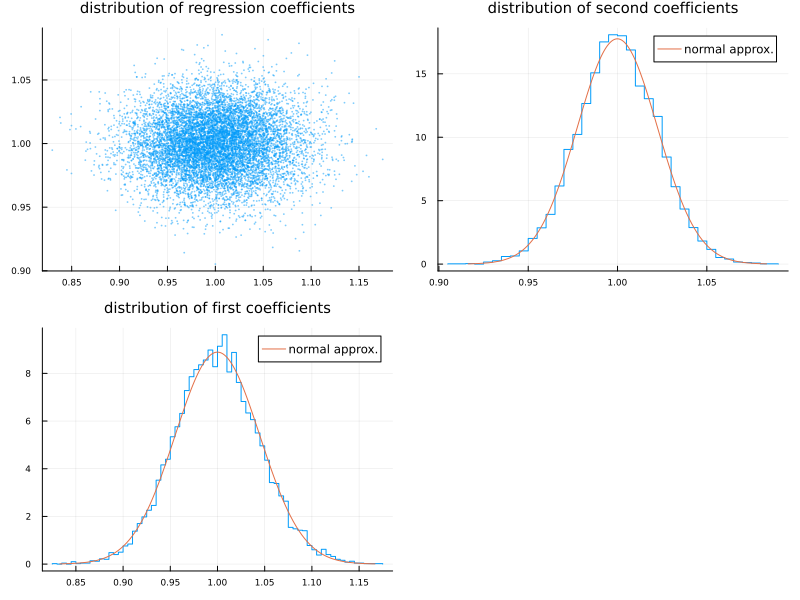

In [10]:
plot_betahat(; n=1000)

以上は標本サイズが $n=1000$ の場合である. 標本サイズが $n=10, 20$ 程度だと正規分布近似の誤差が見える程度になる.

distx = Normal{Float64}(μ=0.0, σ=2.0)
distu = LocationScale{Float64, Continuous, Gamma{Float64}}(
μ: -2.0
σ: 1.0
ρ: Gamma{Float64}(α=2.0, θ=1.0)
)

n = 10

mvnormalapprox_true(; n, distx, a, b, _distu, distu) = FullNormal(
dim: 2
μ: [1.0, 1.0]
Σ: [0.2 -0.0; -0.0 0.05]
)

fit(MvNormal, stack(β̂)) = FullNormal(
dim: 2
μ: [0.9970993172139718, 1.0010103310602096]
Σ: [0.22709303049645777 0.0004573825468453807; 0.0004573825468453807 0.07129564570476357]
)



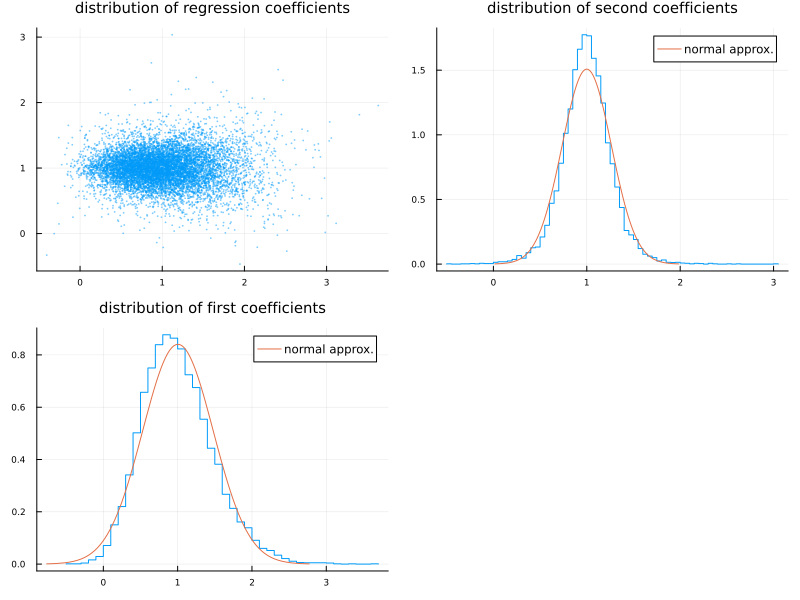

In [11]:
plot_betahat(; n=10)

distx = Normal{Float64}(μ=0.0, σ=2.0)
distu = LocationScale{Float64, Continuous, Gamma{Float64}}(
μ: -2.0
σ: 1.0
ρ: Gamma{Float64}(α=2.0, θ=1.0)
)

n = 20

mvnormalapprox_true(; n, distx, a, b, _distu, distu) = FullNormal(
dim: 2
μ: [1.0, 1.0]
Σ: [0.1 -0.0; -0.0 0.025]
)

fit(MvNormal, stack(β̂)) = FullNormal(
dim: 2
μ: [1.0015593649702201, 1.000551079752403]
Σ: [0.10592400293715178 7.867239155730186e-5; 7.867239155730186e-5 0.02963964681827607]
)



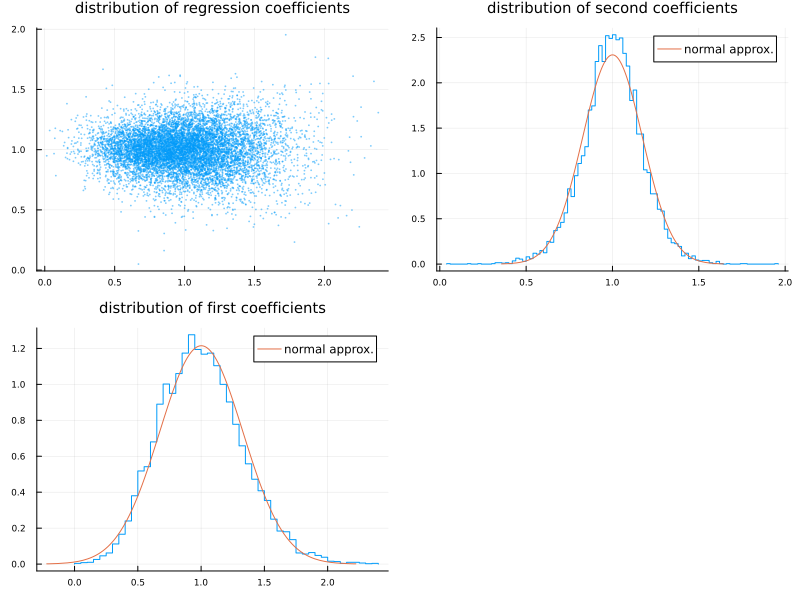

In [12]:
plot_betahat(; n=20)

distx = Normal{Float64}(μ=0.0, σ=2.0)
distu = LocationScale{Float64, Continuous, Gamma{Float64}}(
μ: -2.0
σ: 1.0
ρ: Gamma{Float64}(α=2.0, θ=1.0)
)

n = 40

mvnormalapprox_true(; n, distx, a, b, _distu, distu) = FullNormal(
dim: 2
μ: [1.0, 1.0]
Σ: [0.05 -0.0; -0.0 0.0125]
)

fit(MvNormal, stack(β̂)) = FullNormal(
dim: 2
μ: [1.0001894192170884, 1.0003112909058127]
Σ: [0.05095898483203599 9.187730714675617e-6; 9.187730714675617e-6 0.013614548195057004]
)



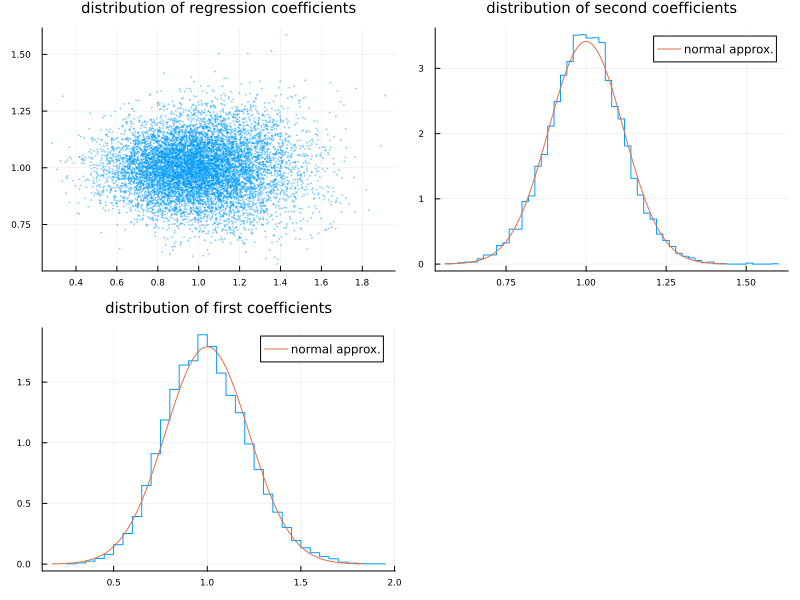

In [13]:
plot_betahat(; n=40)

distx = Normal{Float64}(μ=0.0, σ=2.0)
distu = LocationScale{Float64, Continuous, Gamma{Float64}}(
μ: -2.0
σ: 1.0
ρ: Gamma{Float64}(α=2.0, θ=1.0)
)

n = 100

mvnormalapprox_true(; n, distx, a, b, _distu, distu) = FullNormal(
dim: 2
μ: [1.0, 1.0]
Σ: [0.02 -0.0; -0.0 0.005]
)

fit(MvNormal, stack(β̂)) = FullNormal(
dim: 2
μ: [0.9995649427995333, 0.9997223650112332]
Σ: [0.020325051069374378 -2.4386714839218023e-6; -2.4386714839218023e-6 0.0051868896795820175]
)



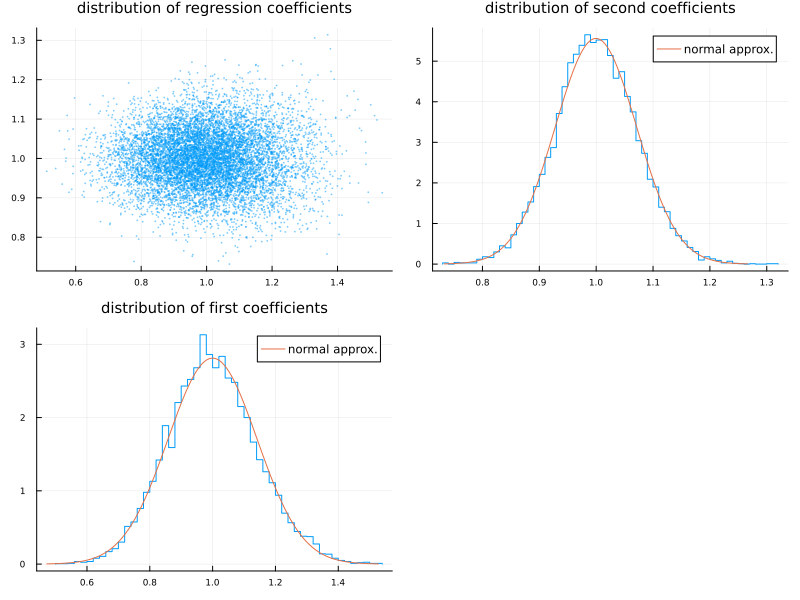

In [14]:
plot_betahat(; n=100)

このようにi.i.d.の残差の分布が正規分布でなくても, 標本サイズが十分に大きければ, 回帰係数の分布は多変量正規分布で近似される.

distx = Normal{Float64}(μ=2.0, σ=2.0)
distu = LocationScale{Float64, Continuous, Gamma{Float64}}(
μ: -2.0
σ: 1.0
ρ: Gamma{Float64}(α=2.0, θ=1.0)
)

n = 10

mvnormalapprox_true(; n, distx, a, b, _distu, distu) = FullNormal(
dim: 2
μ: [1.0, 1.0]
Σ: [0.4 -0.1; -0.1 0.05]
)

fit(MvNormal, stack(β̂)) = FullNormal(
dim: 2
μ: [1.0008312135784254, 0.9989345192303861]
Σ: [0.5145528434991686 -0.1421071743573957; -0.1421071743573957 0.07039630337029448]
)



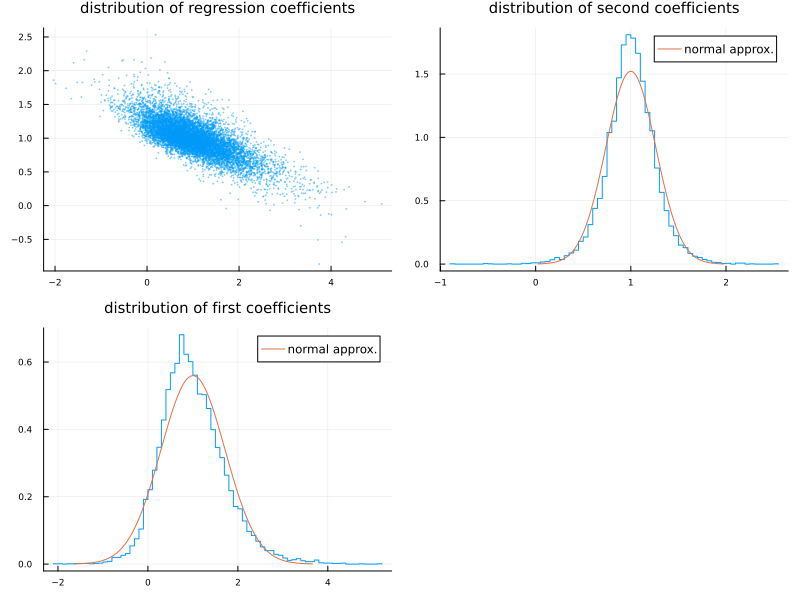

In [15]:
plot_betahat(; distx=Normal(2, 2), n=10)

distx = Normal{Float64}(μ=2.0, σ=2.0)
distu = LocationScale{Float64, Continuous, Gamma{Float64}}(
μ: -2.0
σ: 1.0
ρ: Gamma{Float64}(α=2.0, θ=1.0)
)

n = 20

mvnormalapprox_true(; n, distx, a, b, _distu, distu) = FullNormal(
dim: 2
μ: [1.0, 1.0]
Σ: [0.2 -0.05; -0.05 0.025]
)

fit(MvNormal, stack(β̂)) = FullNormal(
dim: 2
μ: [1.0007645244659154, 1.000578071761013]
Σ: [0.22335930718870398 -0.05868271301888407; -0.05868271301888407 0.02941256013761581]
)



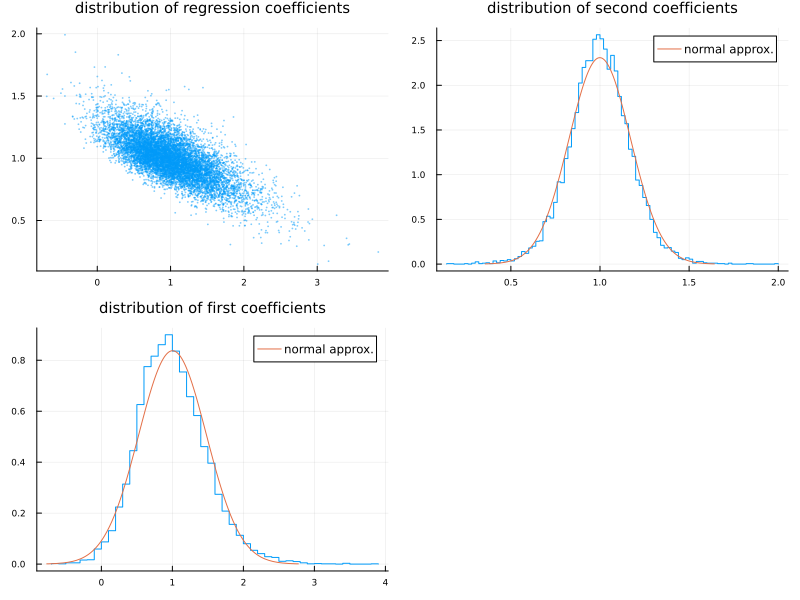

In [16]:
plot_betahat(; distx=Normal(2, 2), n=20)

distx = Normal{Float64}(μ=2.0, σ=2.0)
distu = LocationScale{Float64, Continuous, Gamma{Float64}}(
μ: -2.0
σ: 1.0
ρ: Gamma{Float64}(α=2.0, θ=1.0)
)

n = 40

mvnormalapprox_true(; n, distx, a, b, _distu, distu) = FullNormal(
dim: 2
μ: [1.0, 1.0]
Σ: [0.1 -0.025; -0.025 0.0125]
)

fit(MvNormal, stack(β̂)) = FullNormal(
dim: 2
μ: [0.9985721401892298, 1.0007723415217369]
Σ: [0.10524878530417633 -0.026955939112356775; -0.026955939112356775 0.013462428322351573]
)



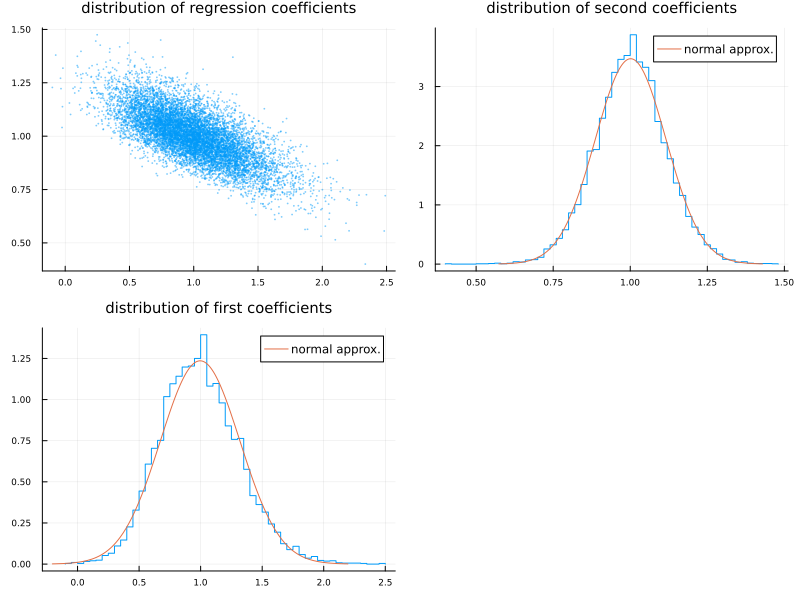

In [17]:
plot_betahat(; distx=Normal(2, 2), n=40)

distx = Normal{Float64}(μ=2.0, σ=2.0)
distu = LocationScale{Float64, Continuous, Gamma{Float64}}(
μ: -2.0
σ: 1.0
ρ: Gamma{Float64}(α=2.0, θ=1.0)
)

n = 100

mvnormalapprox_true(; n, distx, a, b, _distu, distu) = FullNormal(
dim: 2
μ: [1.0, 1.0]
Σ: [0.04 -0.01; -0.01 0.005]
)

fit(MvNormal, stack(β̂)) = FullNormal(
dim: 2
μ: [1.0006858345726817, 0.9999303563240864]
Σ: [0.04077235385177288 -0.010303532131591677; -0.010303532131591677 0.005142750963185664]
)



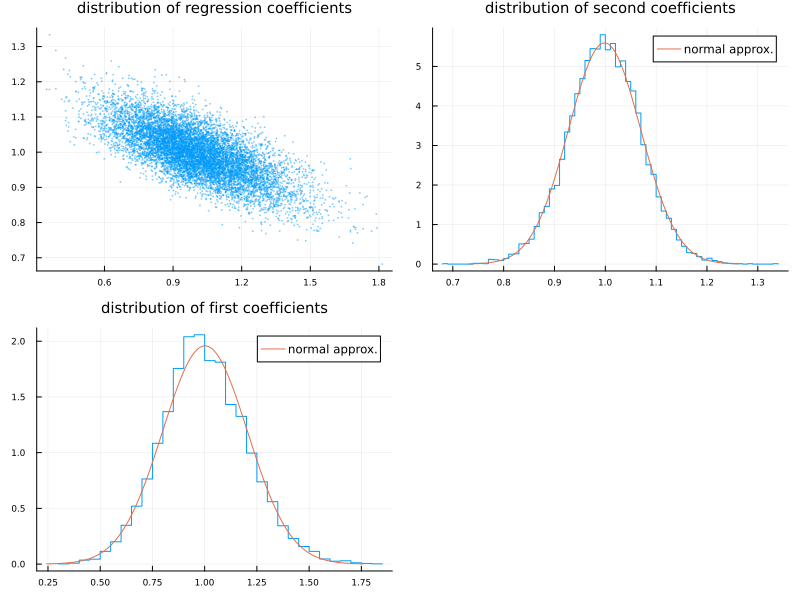

In [18]:
plot_betahat(; distx=Normal(2, 2), n=100)